# _Проекту 4. Компьютер говорит «Нет»_

**Юнит 5. Основные алгоритмы машинного обучения. Часть I (Andrew Glybin)**

## Основная информация

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

**Описания полей:**

* client_id - идентификатор клиента

* education - уровень образования

* sex - пол заемщика

* age - возраст заемщика

* car - флаг наличия автомобиля

* car_type - флаг автомобиля иномарки

* decline_app_cnt - количество отказанных прошлых заявок

* good_work - флаг наличия “хорошей” работы

* bki_request_cnt - количество запросов в БКИ

* home_address - категоризатор домашнего адреса

* work_address - категоризатор рабочего адреса

* income - доход заемщика

* foreign_passport - наличие загранпаспорта

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ

* region_rating - рейтинг региона

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

**Метрика качества**

Результаты оцениваются по площади под кривой ROC AUC

## 1. Импорт библиотек 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# PATH_to_file = '/kaggle/input/sf-dst-scoring/'

In [3]:
from pandas import Series
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [4]:
# изменим параметры для изображений
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
# rcParams['figure.figsize'] = 8, 5
# from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

pd.set_option('display.max_columns', None)
np.set_printoptions(precision=2)


In [5]:
# зафиксируем RANDOM_SEED, версию пакетов, общую текущую дату
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('06/11/2020')

## 2. Импорт данных

In [6]:
# df_train = pd.read_csv(PATH_to_file+'train.csv')
# df_test = pd.read_csv(PATH_to_file+'test.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print('Размерность тренировочного датасета: ', df_train.shape)
print('Размерность тестового датасета: ', df_test.shape)

# sample_submission = pd.read_csv(PATH_to_file+'sample_submission.csv')

Размерность тренировочного датасета:  (73799, 19)
Размерность тестового датасета:  (36349, 18)


In [7]:
df_train.head(1)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0

In [8]:
df_test.head(1)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1   # помечаем где у нас трейн
df_test['sample'] = 0    # помечаем где у нас тест
df_test['default'] = -1  # в тесте у нас нет значения default, мы его должны предсказать, 
                         # но его значения 0 или 1, поэтому заполняем его временно -1 для избежания ошибки

data = df_test.append(df_train, sort=False).reset_index(drop=True)   # объединяем

## 3. Предварительный анализ данных

In [10]:
pandas_profiling.ProfileReport(df_train)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
sample              73799 non-null int64
dtypes: float64(1), int64(13), object(6)
memory usage: 11.3+ MB

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 20 columns):
client_id           36349 non-null int64
app_date            36349 non-null object
education           36178 non-null object
sex                 36349 non-null object
age                 36349 non-null int64
car                 36349 non-null object
car_type            36349 non-null object
decline_app_cnt     36349 non-null int64
good_work           36349 non-null int64
score_bki           36349 non-null float64
bki_request_cnt     36349 non-null int64
region_rating       36349 non-null int64
home_address        36349 non-null int64
work_address        36349 non-null int64
income              36349 non-null int64
sna                 36349 non-null int64
first_time          36349 non-null int64
foreign_passport    36349 non-null object
sample              36349 non-null int64
default             36349 non-null int64
dtypes: float64(1), int64(13), object(6)
memory usage: 5.5+ MB


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
sample              110148 non-null int64
default             110148 non-null int64
dtypes: float64(1), int64(13), object(6)


In [14]:
(data.isna()).sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [15]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

### Резюме по предварительному анализу данных: 

В тренировочной выборке 73799 клиентов, в тестовой выборке 36349. 

Всего имеются данные о 110148 клиентах. 

Всего представлены 20 признаков, из них 1 - временной ряд, 7 бинарных (в т.ч. добавленный признак ***sample***), 6 категориальных и 6 числовых. 

Всего пропусков 478 (307 - в наборе train, 171 - в наборе test), все пропуски в переменной ***education***. 

***client_id*** уникальный числовой признак, который содержит числовой признак клиента. Вероятно, не несет полезной информации для модели. 

Целевая переменная ***default*** является бинарной (True - False).

Сильной корреляции между численными признаками не наблюдается ни в одной из матриц корреляции.

In [16]:
# создаём списки на основании резюме
# client_id, default, sample не включаем в списки

# временной ряд (1)
time_cols = ['app_date']

# бинарные признаки (7-2)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки (6)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые признаки (6-1)
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

# default признаём целевой переменной 
target = 'default'

# ID клиентов удаляем из-за неинформативности
data.drop(['client_id'], axis=1, inplace=True)

## 4. Функции для анализа данных

In [17]:
def outliers(df_col):
    '''
    Определение наличия выбросов в отдельном признаке датасета.
    Расчёт данных описательной статистики. Определение границ выбросов.
    Подсчёт общего количества выбросов в признаке.
    
    df_col - название столбца датасета. 
    
    '''
    
    q1 = df_train[df_col].quantile(0.25)
    q3 = df_train[df_col].quantile(0.75)
    IQR = q3 - q1
    low = q1 - (1.5 * IQR)
    high = q3 + (1.5 * IQR)
    for i in df_train[df_col]:
        if (i <= low) or (i >= high):
            print("В признаке '{}' есть значения, которые могут считаться выбросами".format(df_col))
            break
        
    print("Количество выбросов в признаке '{}': {}."
          .format(df_col, ((df_train[df_col] < (q1 - 1.5 * IQR)) | (df_train[df_col] > (q3 + 1.5 * IQR))).sum()))
    print("25-й процентиль: {}, 75-й процентиль: {}, IQR: {}, Границы выбросов: [{}, {}]".format(q1, q3, IQR, low, high))
    

In [18]:
def numerical_features(item_name, n_bins=100):
    '''
    Функция для анализа численных признаков.
    
    Рисует следующие графики:
    - боксплот `sns.boxplot()`: удобно выявлять аномалии
    - распределение `sns.distplot()`
     
    Вычисляет базовые статистические показатели `.describe()` 
        
    item_name - название численного признака датасета.
    
    '''
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        
    # boxplot    
    df_train.boxplot(column=item_name, ax=axes[0])
    axes[0].set_title(item_name, fontsize=22)
    
    # distplot
    sns.distplot(df_train[item_name], bins=n_bins, kde=False, ax=axes[1], vertical=True)
    axes[1].set_title(item_name, fontsize=22)
    plt.xticks(rotation=45)
         
    # descriptive statistics
    print(pd.DataFrame(df_train[item_name].describe()).T, "\n")


In [19]:
def split(df):
    '''
    Функция для разбиения датасета на тренировочный и валидационный
    
    '''
    
    y = df.default.values            
    x = df.drop(columns=['default'])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
    return X_train, X_test, y_train, y_test


In [20]:
def all_metrics(y_true, y_pred, y_pred_prob):
    '''
    Функция выводит в виде датафрейма значения основных метрик классификации
    
    '''
    
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==1)&(y_pred==0))
    FN = np.sum((y_true==0)&(y_pred==1))
    
    dict_metric['P'] = [P,'Наличие дефолта']
    dict_metric['N'] = [N,'Отсутствие дефолта']
    dict_metric['TP'] = [TP,'Верно принято']
    dict_metric['TN'] = [TN,'Верно отвергнуто']
    dict_metric['FP'] = [FP,'Ошибка первого рода']
    dict_metric['FN'] = [FN,'Ошибка второго рода']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность определения'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Гармоническое среднее Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'Площадь под кривой ошибок']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание'])
    display(temp_df)   
    

In [21]:
def show_confusion_matrix(lastmodel):
    '''
    Функция отображает пару confusion-матриц:
    с абсолютными значениями и нормализованную.
    
    На вход подаётся последняя модель.
    Функция использует тестовые значения выборки и целевого признака.
    
    '''
    
    class_names = ['NonDefault', 'Default']
    titles_options = [("Confusion matrix без нормализации", None),
                      ("Нормализованная confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(lastmodel, X_test, y_test, 
                                     display_labels=class_names, 
                                     cmap=plt.cm.Blues, 
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    

In [22]:
def show_roc_curve(lastmodel):
    '''
    Функция отображает ROC-кривую.
    
    На вход подаётся последняя модель.
    Функция использует тестовые значения выборки и целевого признака.
    
    '''
    
    probs = lastmodel.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label = 'Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    

## 5. Анализ датасета по признакам.

### 5.1 Численные признаки:

Количество выбросов в признаке 'age': 0.
25-й процентиль: 30.0, 75-й процентиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]
       count       mean        std   min   25%   50%   75%   max
age  73799.0  39.280641  11.520378  21.0  30.0  37.0  48.0  72.0 

В признаке 'decline_app_cnt' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'decline_app_cnt': 12585.
25-й процентиль: 0.0, 75-й процентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]
                   count      mean       std  min  25%  50%  75%   max
decline_app_cnt  73799.0  0.275749  0.804272  0.0  0.0  0.0  0.0  33.0 

В признаке 'score_bki' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'score_bki': 351.
25-й процентиль: -2.259533835, 75-й процентиль: -1.56983126, IQR: 0.6897025750000001, Границы выбросов: [-3.2940876975, -0.5352773974999998]
             count      mean       std       min       25%       50%  \
score_bki  73799.0 -1.904724  0.498231 -3.62

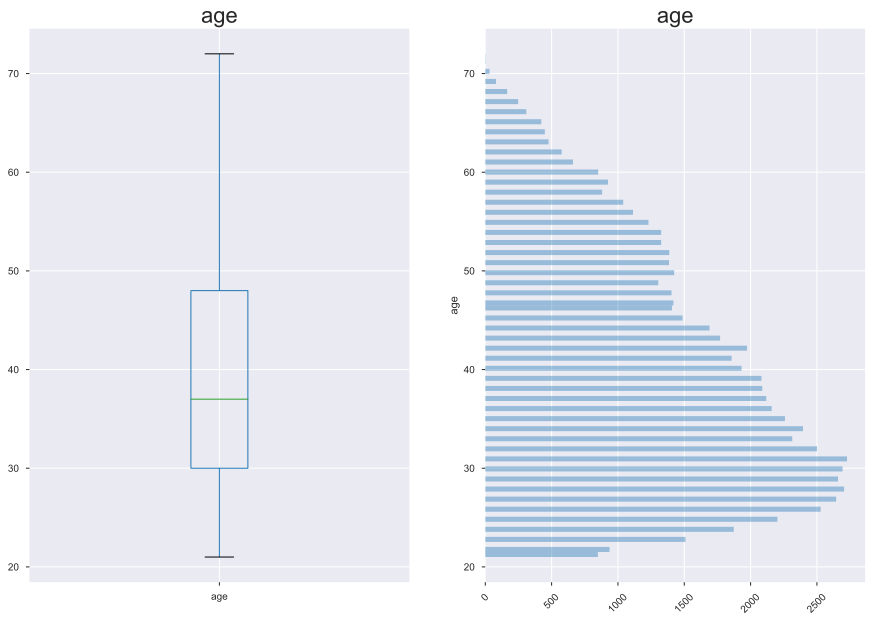

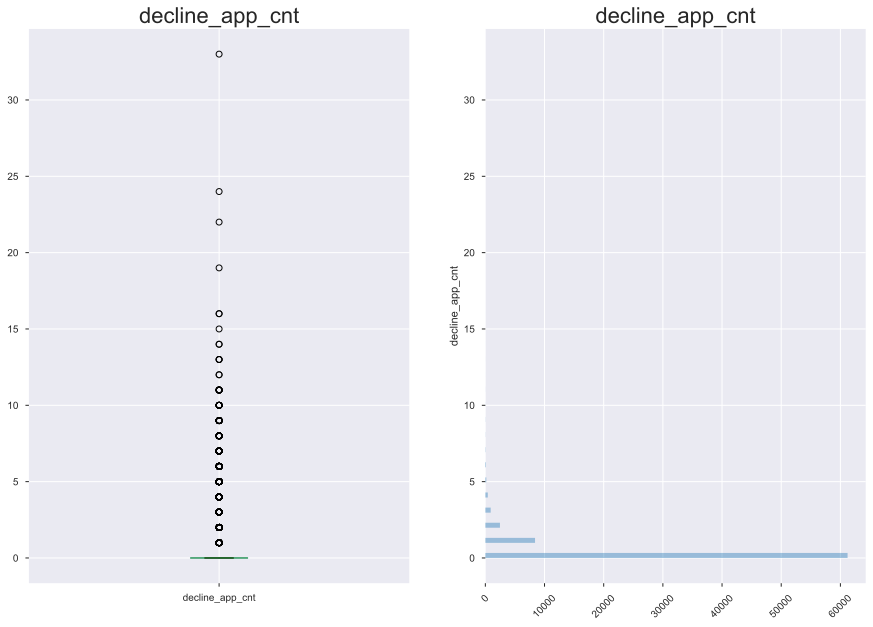

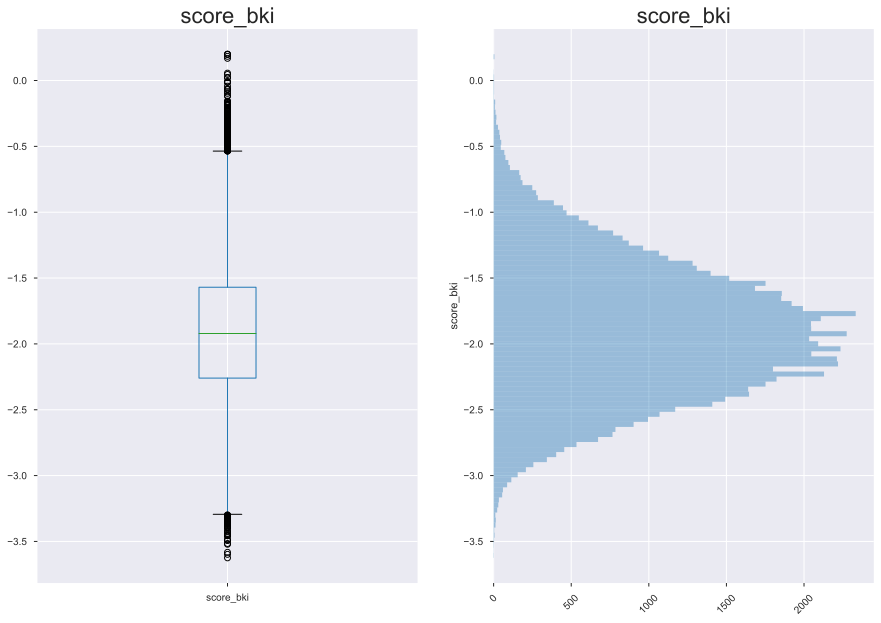

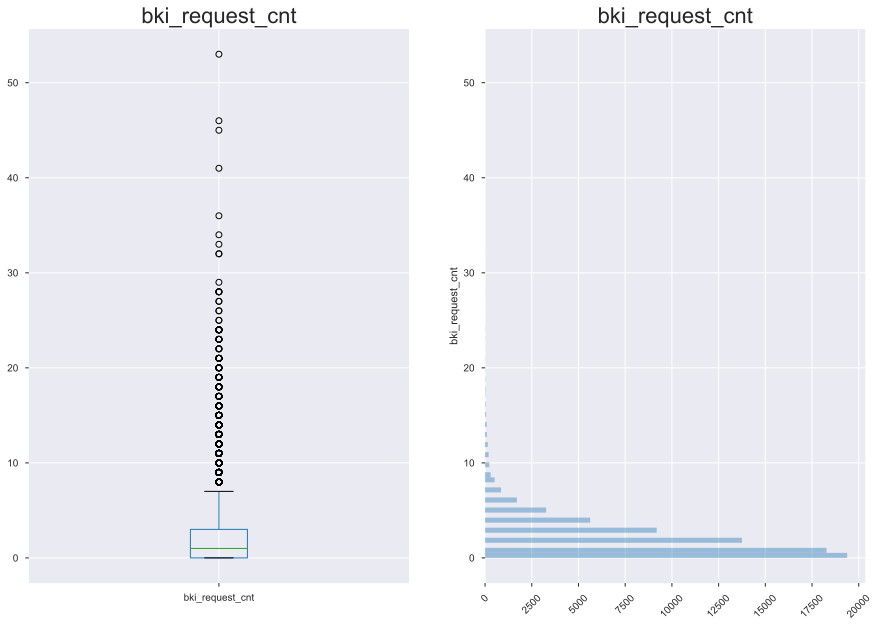

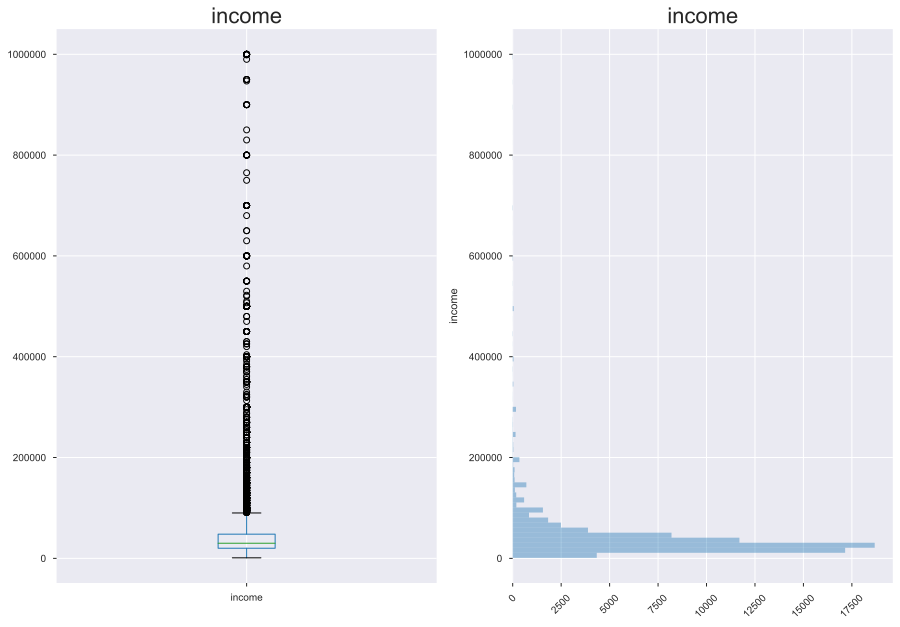

In [23]:
for col in num_cols:
    outliers(col)
    numerical_features(col)

#### Резюме по численным признакам:

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост. 

**age**: Распределение логнормальное, выбросов по квартилям нет. Признак будем использовать, как есть.

**decline_app_cnt**: Распределение логнормальное, выбросов очень много. Возьмём логарифм, чтобы избежать чувствительности к сильным отклонениям. Выбросы удалять пока не будем. Возможно это потребуется для улучшения модели.

**score_bki**: Распределение нормальное. Выбросов не много, удалять не будем.

**bki_request_cnt**: Распределение логнормальное, выбросов не много, удалять не будем. Возьмём логарифм, чтобы сделать распределение более нормальным.

**income**: Распределение логнормальное, выбросов очень много, удалять их пока не будем. Возьмём логарифм. К вопросу об удалении выбросов вернемся после построения модели при необходимости.

In [24]:
# логорифмируем "плохие" показатели
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    data[i] = np.log(data[i] + 1)
   

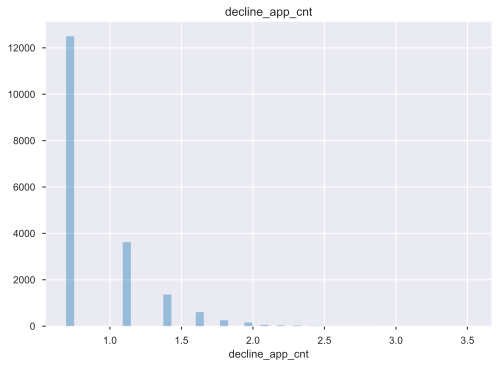

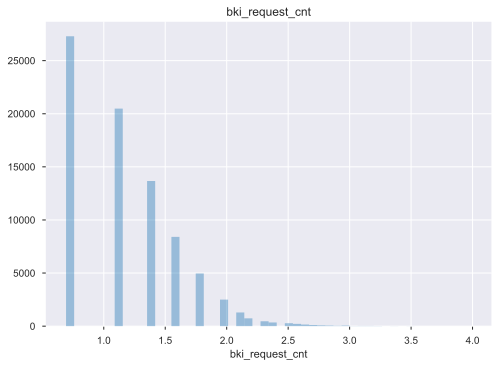

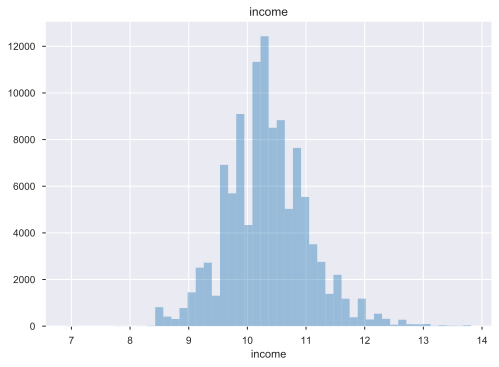

In [25]:
# построим повторно графики для скорректированных показателей
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Признак ***income*** стал менее смещённым. Выбросов стало меньше во всех скорректированных признаках. Однако признаки ***decline_app_cnt*** и ***bki_request_cnt*** требуют дополнительного анализа.

### 5.2 Преобразование временного ряда.


In [26]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data.head(3)

app_date education sex  age car car_type  decline_app_cnt  good_work  \
0 2014-03-22       GRD   M   29   Y        Y         0.000000          0   
1 2014-01-24       SCH   F   39   N        N         1.791759          0   
2 2014-03-23       UGR   M   50   Y        Y         0.000000          0   

   score_bki  bki_request_cnt  region_rating  home_address  work_address  \
0  -2.271884         1.386294             50             1             2   
1  -1.504999         1.098612             50             1             2   
2  -1.691339         0.693147             50             1             2   

      income  sna  first_time foreign_passport  sample  default  
0  10.819798    1           4                N       0       -1  
1   8.517393    4           3                N       0       -1  
2  10.308986    1           3                Y       0       -1

In [27]:
# проверим начало и конец периода нашего датасета 
start = data.app_date.min()
end = data.app_date.max()
start, end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Представленный датасет охватывает период с 1 января по 30 апреля 2014 года. Можно создать дополнительный численный признак, отражающий количество дней от старта датасета до конкретной записи. Это необходимо сделать, т.к. собственно сам временной ряд необходимо будет позже исключить из датасета перед построением модели.

In [28]:
data['app_date_delta'] = (data.app_date - start).dt.days.astype('int')

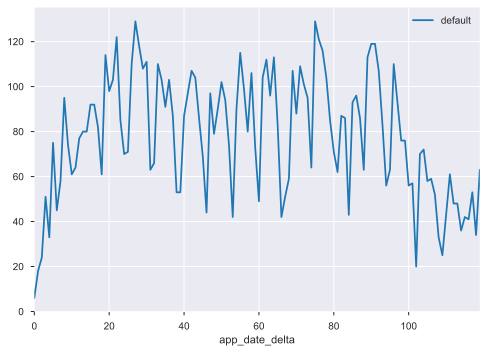

In [29]:
# проверим количество дефолтов в течение срока, отражённого в представленном датасете
data_temp = data.loc[data['sample'] == 1] 
data_temp[['default'] + ['app_date_delta']].groupby('app_date_delta').sum().plot()

#### **ВАЖНО!** 
Количество дефолтов с ориентировочно 90 дня от начала датасета начало снижаться. Предположительно, были введены некие заградительные меры от выдачи рискованных кридетов и, очевидно, что это необходимо будет учитывать при построении модели, т.к. её поведение неоднородно в течение анализируемого периода.

In [30]:
# добавление нового признака в список числовых признаков
num_cols.append('app_date_delta')

# удаление временного ряда из датасета
data.drop(['app_date'], axis=1, inplace=True)

### 5.3 Оценка значимости непрерывных переменных.

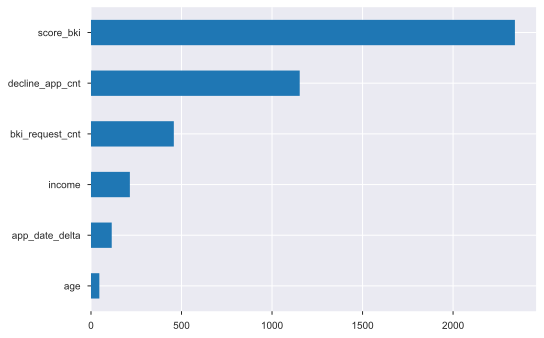

In [31]:
imp_num = Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Резюме по оценке значимости числовых переменных:
Скорринговый балл БКИ (**score_bki**) является самым значимым показателем согласно однофакторного дисперсионного анализа, менее значимым является кол-во отказанных ранее заявок (**declain_app_cnt**). Остальные признаки не оказывают существенного влияния на целевой показатель. Признак decline_app_cnt имеет очень большое количество выбросов и "плохое" распределения для модели. Нужно будет провести дополнительную работу.

### 5.4 Категориальные и бинарные признаки:

В ходе предварительного анализа данных было выявлено наличие пропусков только в одном признаке - **education**. 
Устраним эти пропуски, заполним значением IDK (неизвестно).   
Кроме того, имеется информация, что категории в данном признаке имеют следующие значение:
* SCH    (школа)
* GRD    (бакалавр)
* UGR    (кандидат в бакалавры)
* PGR    (магистр)
* ACD    (академик)

In [32]:
data.education.fillna('IDK', inplace=True)   

In [33]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
IDK      478
ACD      291
Name: education, dtype: int64

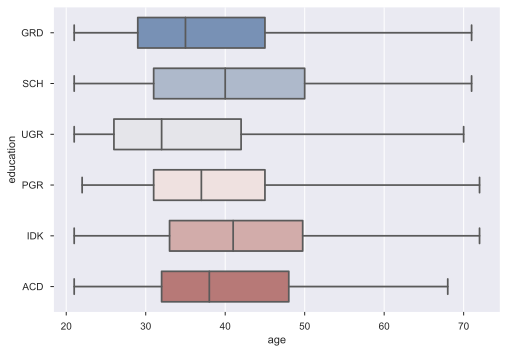

In [34]:
# оценим их распределение визуально
sns.boxplot(x="age", y="education", data=data, whis=[0, 100], width=.6, palette="vlag")

Очевидно, что пропущенные значения (отмечены IDK) распределены почти аналогично с клиентами, имеющими только базовое образование. 
Преобразовать признак "education" в числовой формат можно с помощью LabelEncoder, но  тогда будет потерян вес образования, который, возможно, имеет влияние на целевую переменную.
Поэтому, предлагается провести преобразование с помощью словаря, назначив "веса" различным типам образования.
    

In [35]:
data.education = data.education.replace({'IDK': 0, 'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5})

In [36]:
# перевод бинарных признаков в числовой формат

label_encoder = LabelEncoder()

for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [37]:
data.sample(3)

education  sex  age  car  car_type  decline_app_cnt  good_work  \
44603          3    1   35    0         0         0.693147          0   
37738          1    0   56    0         0         0.000000          0   
51080          1    1   32    1         1         0.000000          1   

       score_bki  bki_request_cnt  region_rating  home_address  work_address  \
44603  -1.723624         1.098612             50             2             3   
37738  -1.586444         0.000000             50             1             1   
51080  -2.557837         0.000000             70             1             3   

          income  sna  first_time  foreign_passport  sample  default  \
44603  10.126671    4           3                 0       1        0   
37738   9.903538    1           4                 0       1        0   
51080  10.915107    1           4                 0       1        0   

       app_date_delta  
44603              20  
37738              50  
51080              25

### 5.5 Оценка значимости категориальных и бинарных переменных.

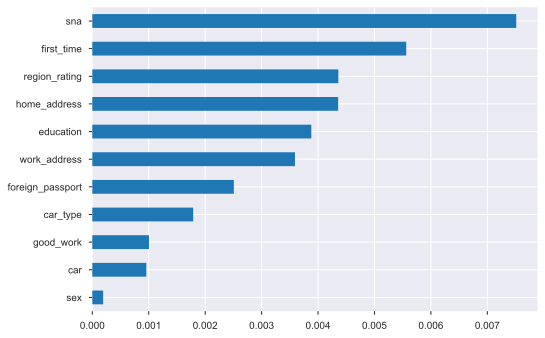

In [38]:
# для бинарных и категориальных признаков (переведенных в числа)
data_temp = data.loc[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### Резюме по оценке значимости категориальных и бинарных переменных:
Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (**sna**). Далее, давность наличия информации о заемщике (**first_time**), а затем, практически с одинаковым значением, идет рейтинг региона (**region_rating**) и категоризатор домашнего адреса (**home_address**). Ещё одним достаточно значимым для модели признаком явялется уровень образования клиента (**education**)

## 6. Подготовка данных к машинному обучению.

### Определение дисбаланса классов

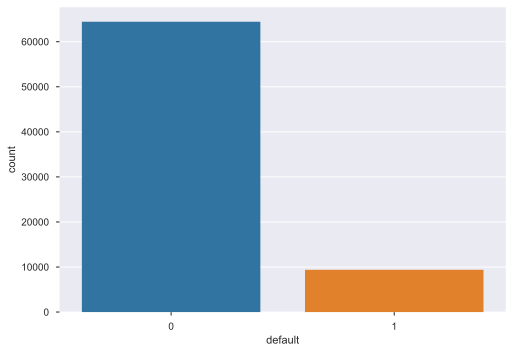

In [39]:
sns.countplot(data_temp['default'])

In [40]:
data_temp['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Несмотря на значительное различие по количеству дефолтных и надёжных клиентов, явного дисбаланса классов нет. Согласно теории, когда мы используем вероятностные модели для бинарной классификации, во время обучения модели не сильно зависят от баланса классов, а при тестировании будет использоваться метрика ROC_AUC, обладающая низкой чувствительностью к балансу классов. 

### Применение dummy-кодированием для категориальных переменных

In [41]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

### Стандартизация числовых признаков

In [42]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = data[num_cols].columns)

### Верификация случайных строк датасета

In [43]:
display(data.sample(2))

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
39020    1 -0.803039    1         1        -0.418815          0  -1.474745   
43786    0 -0.108474    0         0        -0.418815          0   0.453259   

       bki_request_cnt    income  foreign_passport  sample  default  \
39020         0.333797  0.680425                 0       1        0   
43786         1.386150  1.524166                 0       1        0   

       app_date_delta  education_0  education_1  education_2  education_3  \
39020       -0.840863            0            0            0            1   
43786       -0.092638            0            0            1            0   

       education_4  education_5  region_rating_20  region_rating_30  \
39020            0            0                 0                 0   
43786            0            0                 0                 0   

       region_rating_40  region_rating_50  region_rating_60  region_rating_70  \
39020                 0                 1                 0                 0   
43786                 0                 0                 0                 0   

       region_rating_80  home_address_1  home_address_2  home_address_3  \
39020                 0               1               0               0   
43786                 1               0               1               0   

       work_address_1  work_address_2  work_address_3  sna_1  sna_2  sna_3  \
39020               0               1               0      1      0      0   
43786               0               0               1      0      0      0   

       sna_4  first_time_1  first_time_2  first_time_3  first_time_4  
39020      0             0             1             0             0  
43786      1             0             0             0             1

### Выделение тренировочной и тестовой частей датасета

In [44]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# y = train_data.default.values            # наш таргет
# X = train_data.drop(['default'], axis=1)

## 7. Построение модели

### Разбиение тренировочного датасета на тренировочную и валидационную части


In [45]:
X_train, X_test, y_train, y_test = split(train_data)

In [46]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, X_test.shape

((36349, 39), (73799, 39), (59039, 38), (14760, 38))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [47]:
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

Значение                                  Описание
P           1827.000000                           Наличие дефолта
N          12933.000000                        Отсутствие дефолта
TP            40.000000                             Верно принято
TN         12871.000000                          Верно отвергнуто
FP          1787.000000                       Ошибка первого рода
FN            62.000000                       Ошибка второго рода
Accuracy       0.874729                   Доля верно определённых
Precision      0.392157                      Точность определения
Recall         0.021894                       Полнота определения
F1-score       0.041472  Гармоническое среднее Precision и Recall
ROC_AUC        0.744681                 Площадь под кривой ошибок

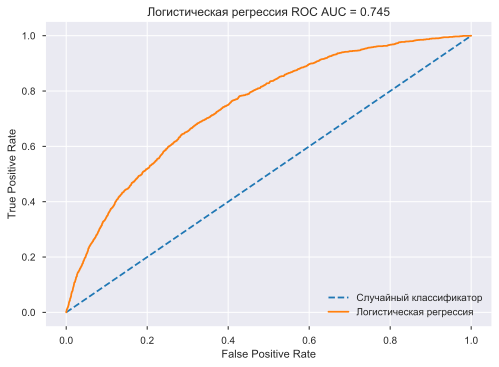

Confusion matrix без нормализации
[[12871    62]
 [ 1787    40]]
Нормализованная confusion matrix
[[1.   0.  ]
 [0.98 0.02]]


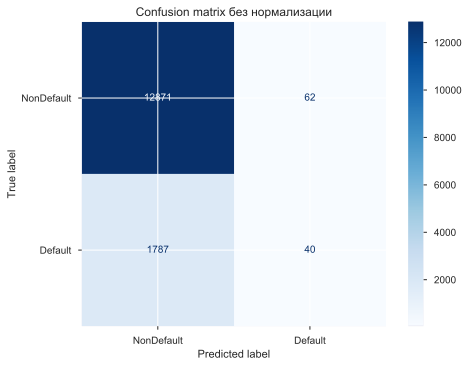

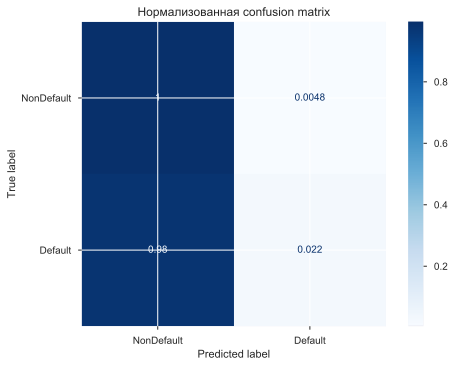

In [48]:
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(model)
show_confusion_matrix(model)

### Выводы по результатам работы первой модели

Несмотря на относительно высокий показатель ROC_AUC, модель показывает абсолютно неудовлетворительную работу. Об этом свидетельствует очень низкий показатель количества правильных предсказаний от всего класса истинных значений (Recall). Т.о. велика вероятность дефолта по выданным кредитам и прямая потеря банком ресурсов. 

### Поиск оптимальных параметров модели

In [49]:
# best practice by @Анна Нохрина
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
modelbest = gridsearch.best_estimator_

# вывод параметров
best_parameters = modelbest.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s = %r' % (param_name, best_parameters[param_name]))
   

	C = 1.0
	class_weight = 'balanced'
	dual = False
	fit_intercept = True
	intercept_scaling = 1
	l1_ratio = None
	max_iter = 50
	multi_class = 'auto'
	n_jobs = None
	penalty = 'l1'
	random_state = 42
	solver = 'liblinear'
	tol = 0.001
	verbose = 0
	warm_start = False


In [50]:
# печатаем метрики
preds = modelbest.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.6706
Precision: 0.2262
Recall: 0.6864
F1: 0.3403


#### Резюме:
Полученный результат показывает значительный рост метрик полноты и f1_score.
Есть надежда, что модель будет работать лучше.


### Построение модели после первой оптимизации

In [51]:
model_2 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight = 'balanced', 
                           dual = False, 
                           fit_intercept = True, 
                           intercept_scaling = 1, 
                           l1_ratio = None, 
                           multi_class = 'auto', 
                           n_jobs = None, 
                           penalty = 'l1', 
                           solver = 'liblinear', 
                           tol = 0.001, 
                           verbose = 0, 
                           warm_start = False)

model_2.fit(X_train, y_train)

y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

### Оценка качества оптимизированной модели

Значение                                  Описание
P           1827.000000                           Наличие дефолта
N          12933.000000                        Отсутствие дефолта
TP          1254.000000                             Верно принято
TN          8644.000000                          Верно отвергнуто
FP           573.000000                       Ошибка первого рода
FN          4289.000000                       Ошибка второго рода
Accuracy       0.670596                   Доля верно определённых
Precision      0.226231                      Точность определения
Recall         0.686371                       Полнота определения
F1-score       0.340299  Гармоническое среднее Precision и Recall
ROC_AUC        0.744161                 Площадь под кривой ошибок

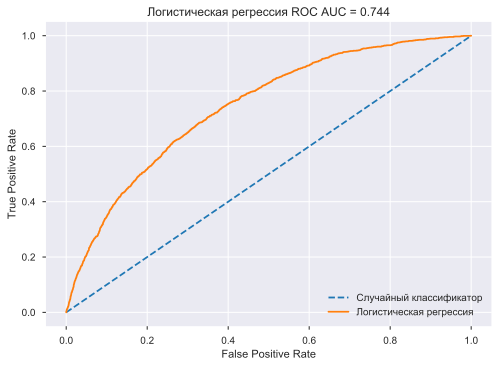

Confusion matrix без нормализации
[[8644 4289]
 [ 573 1254]]
Нормализованная confusion matrix
[[0.67 0.33]
 [0.31 0.69]]


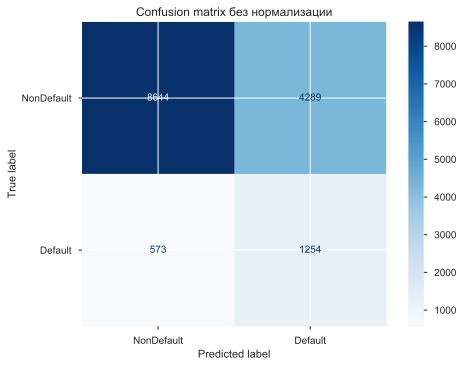

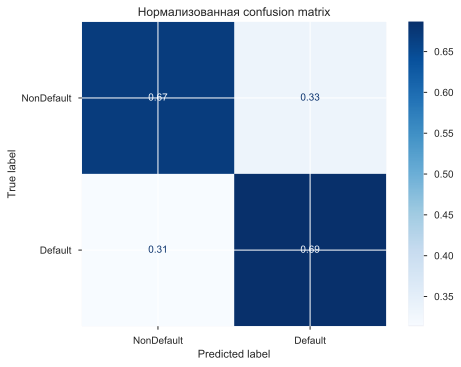

In [52]:
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(model_2)
show_confusion_matrix(model_2)

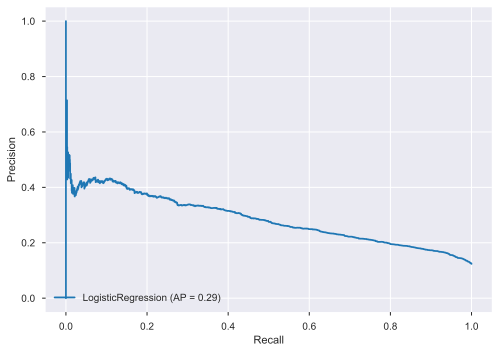

In [53]:
plot_precision_recall_curve(model_2, X_test, y_test)

### Выводы по результатам первой оптимизации модели

Качество работы модели значительно улучшилось. Её работа позоляет предсказать почти 70% возможных дефолтов по выданным кредитам. Однако модель отказывает трети надёжных клиентов, что потенциально приведёт к недополучению банком прибыли. 

## 8. Submission

Восстановим повторно тренировочный и тестовый датафреймы из объединённого датасета.

In [54]:
data.sample(2)

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
51873    1  0.065167    0         0        -0.418815          1  -0.407315   
46299    1 -0.889859    1         1        -0.418815          0   1.469260   

       bki_request_cnt    income  foreign_passport  sample  default  \
51873         0.770563  1.675407                 0       1        0   
46299        -0.281790  1.675407                 1       1        0   

       app_date_delta  education_0  education_1  education_2  education_3  \
51873       -0.404399            0            0            0            1   
46299       -1.495559            0            0            1            0   

       education_4  education_5  region_rating_20  region_rating_30  \
51873            0            0                 0                 0   
46299            0            0                 0                 0   

       region_rating_40  region_rating_50  region_rating_60  region_rating_70  \
51873                 0                 1                 0                 0   
46299                 0                 0                 0                 0   

       region_rating_80  home_address_1  home_address_2  home_address_3  \
51873                 0               1               0               0   
46299                 1               0               1               0   

       work_address_1  work_address_2  work_address_3  sna_1  sna_2  sna_3  \
51873               1               0               0      1      0      0   
46299               0               0               1      1      0      0   

       sna_4  first_time_1  first_time_2  first_time_3  first_time_4  
51873      0             0             0             1             0  
46299      0             0             1             0             0

In [55]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [56]:
# назначение тренировочной и тестовой части выборки
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [57]:
X_test.head(3)

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 -0.889859    1         1        -0.418815          0  -0.735587   
1    0 -0.021654    0         0         4.539989          0   0.800039   
2    1  0.933372    1         1        -0.418815          0   0.426908   

   bki_request_cnt    income  foreign_passport  app_date_delta  education_0  \
0         0.770563  0.680425                 0        0.593234            0   
1         0.333797 -2.624624                 0       -1.183799            0   
2        -0.281790 -0.052834                 1        0.624410            0   

   education_1  education_2  education_3  education_4  education_5  \
0            0            0            1            0            0   
1            1            0            0            0            0   
2            0            1            0            0            0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 1   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               1   
2                 0                 0                 0               1   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               0               1   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      1      0      0      0             0             0   
1               0      0      0      0      1             0             0   
2               0      1      0      0      0             0             0   

   first_time_3  first_time_4  
0             0             1  
1             1             0  
2             1             0

In [58]:
# sample_submission

In [59]:
predict_submission = model_2.predict_proba(X_test)[:,1]

In [60]:
submission = pd.DataFrame(df_test.client_id)
submission['default'] = predict_submission
submission.to_csv('submission.csv', index=False)

In [61]:
submission

client_id   default
0          74835  0.205686
1          17527  0.793043
2          75683  0.301044
3          26883  0.408621
4          28862  0.139398
...          ...       ...
36344      83775  0.769020
36345     106254  0.115843
36346      81852  0.782464
36347       1971  0.626406
36348      69044  0.700416

[36349 rows x 2 columns]

## Выводы

Модель требует доработки с т.ч. избавления от неинформативных признаков, возможны экперименты с созданием полиноминальных признаков.
Неободимо убрать выбросы в существующих признаках и оценить изменения оценки качества новой модели.
Однако, в рамках 48-формата выполнения проекта, я просто не рештился на вышеназванные эксперименты с признаками.
Отдельное спасибо Анне за предоставленный фрагмент кода для поиска оптимальных гиперпараметров модели. 